In [1]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import random
import datetime
import statsmodels as sm
import statsmodels.tsa.api as smt
from helper_functions import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Time Series & Forecasting

A *time series* is a specific type of data, where measurements of a single quantity are taken over time.

"A time series is a sequence of random variables, $x_1, x_2, x_3, ...$, where the random variable $x_1$ denotes the value taken by the series at the first time point...

The collection of random variables, {$x_t$}, indexed by $t$ is referred to as a *stochastic process*. $t$ in this sense is discrete and varies over integers $t = 0, \pm1, \pm2, \pm3, ...$, or some subset of integers." -- *Time Series Statistical Models*

*Some thinking out loud*

So we can approach time series & forecasting in two ways, as a statistician, or as a computer... The first option, as a statistician, requires we think of the time series values as *counts* (regression), which are poisson distributed. If we looked at a monetary value, it would be (log)-normally distributed. This process would lead to an Arima/Sarimax model which is some branch of Linear Regression, therefore is more complicated to satisfy all of the regression assumptions.

If we instead fancy ourselves computers, we could throw the counts or monetary values (really whatever) to a neural net like FB's Prophet since neural nets do not care to understand distributions.

---

## The Problem

Kaggle Comp: [M5 Forecasting - Accuracy: Estimate the unit sales of Walmart retail goods](https://www.kaggle.com/c/m5-forecasting-accuracy/data)

* Predicting item sales at Wallmart stores in California, Texas, and Wisconsin for two 28-day time periods.

First there's some merging/cleaning/exploring... we start with three csvs:

1. `sales_train_evaluation.csv`
2. `calendar.csv`
3. `sell_prices.csv`

## Exploratory Data Analysis
---

In [ ]:
train_sales = pd.read_csv("data/sales_train_evaluation.csv")
calendar = pd.read_csv("data/calendar.csv")
sell_prices = pd.read_csv("data/sell_prices.csv")

In [ ]:
train_sales.shape, calendar.shape, sell_prices.shape

((2626, 1947), (1969, 14), (631068, 4))

#### Starting with `train_sales`

In [ ]:
train_sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [ ]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Columns: 1947 entries, id to d_1941
dtypes: float64(951), int64(990), object(6)
memory usage: 39.0+ MB


In [ ]:
categorical_cols = train_sales.select_dtypes(include=['object'])

for col in categorical_cols:
    print(f'{col}:\n{np.unique(train_sales[col], return_counts=True)}\n')

id:
(array(['FOODS_1_001_CA_1_evaluation', 'FOODS_1_002_CA_1_evaluation',
       'FOODS_1_003_CA_1_evaluation', ...,
       'HOUSEHOLD_2_514_CA_1_evaluation',
       'HOUSEHOLD_2_515_CA_1_evaluation',
       'HOUSEHOLD_2_516_CA_1_evaluation'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

item_id:
(array(['FOODS_1_001', 'FOODS_1_002', 'FOODS_1_003', ...,
       'HOUSEHOLD_2_514', 'HOUSEHOLD_2_515', 'HOUSEHOLD_2_516'],
      dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

dept_id:
(array(['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2'], dtype=object), array([216, 398, 400, 416, 149, 532, 515]))

cat_id:
(array(['FOODS', 'HOBBIES', 'HOUSEHOLD'], dtype=object), array([1014,  565, 1047]))

store_id:
(array(['CA_1'], dtype=object), array([2626]))

state_id:
(array(['CA'], dtype=object), array([2626]))



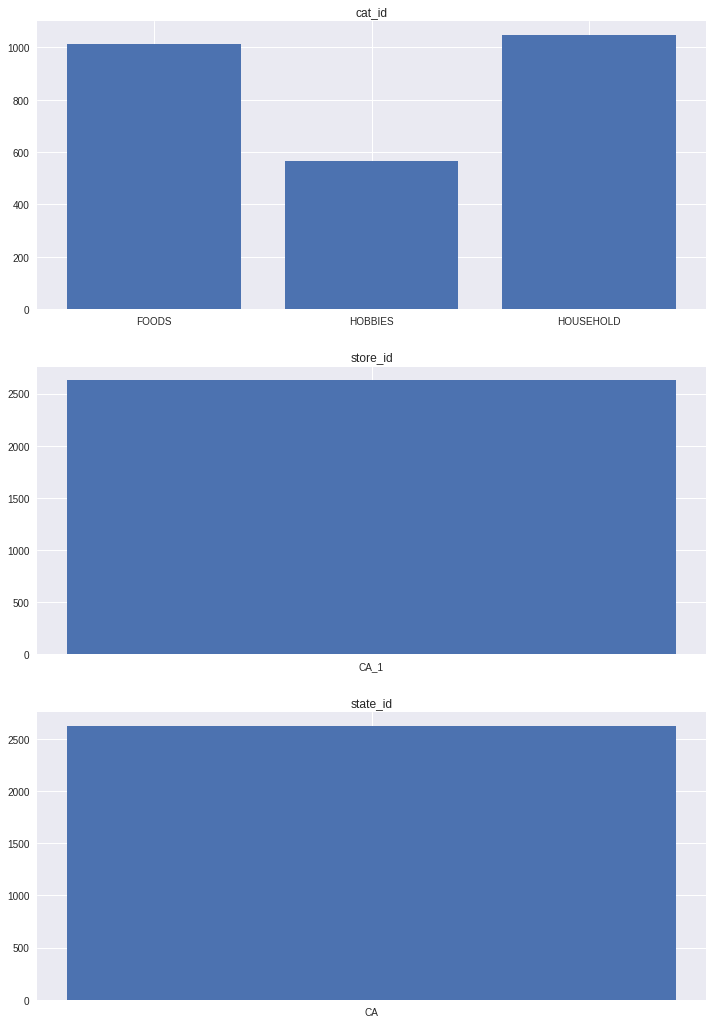

In [ ]:
columns = ['cat_id', 'store_id', 'state_id']

x = []
y = []

for col in columns:
    values, counts = np.unique(train_sales[col], return_counts=True)
    x.append(values)
    y.append(counts)

fig, ax = plt.subplots(3, figsize=(12, 18))
for i, ((xi, yi), col) in enumerate(zip(zip(x, y), columns)):
    ax[i].bar(xi, yi)
    ax[i].set_title(col);

#### Next `calendar`

In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [ ]:
fig = plot_missing_values(calendar, 'Calendar')
fig.show()

In [ ]:
to_drop = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
calendar.drop(to_drop, axis=1, inplace=True)

In [ ]:
categorical_cols = calendar.select_dtypes(include=['object'])

for col in categorical_cols:
    print(f'{col}:\n{np.unique(calendar[col], return_counts=True)}\n')

date:
(array(['2011-01-29', '2011-01-30', '2011-01-31', ..., '2016-06-17',
       '2016-06-18', '2016-06-19'], dtype=object), array([1, 1, 1, ..., 1, 1, 1]))

weekday:
(array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object), array([281, 281, 282, 282, 281, 281, 281]))

d:
(array(['d_1', 'd_10', 'd_100', ..., 'd_997', 'd_998', 'd_999'],
      dtype=object), array([1, 1, 1, ..., 1, 1, 1]))



#### Lastly `sell_prices`

In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325.0,9.58
1,CA_1,HOBBIES_1_001,11326.0,9.58
2,CA_1,HOBBIES_1_001,11327.0,8.26
3,CA_1,HOBBIES_1_001,11328.0,8.26
4,CA_1,HOBBIES_1_001,11329.0,8.26


In [ ]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631068 entries, 0 to 631067
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   store_id    631068 non-null  object 
 1   item_id     631068 non-null  object 
 2   wm_yr_wk    631067 non-null  float64
 3   sell_price  631067 non-null  float64
dtypes: float64(2), object(2)
memory usage: 19.3+ MB


---
## Thoughts on moving forward...

* `train_sales` rows are products, columns are days - looks like a pivoted dataframe, which makes it hard to merge/join with the `calendar`
* Can melt `train_sales` to create an *un-pivoted* table using [`pd.melt`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)
* There is a total of 1913 days = 5 years; 2011 - 2016
* `calendar` rows are days with timeseries object in `date` column
* Can merge `sell_price.item_id` with `train_sales.item_id` to add `sell_price`
* The last bullet doesn't sound as appealing bc most forecasting problems are for inventory *demand*

---

In [ ]:
train_sales_melt = pd.melt(train_sales, 
            id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
            var_name='d', value_name='item_sales').loc[:5000000]

In [ ]:
train_sales_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [ ]:
df = pd.merge(train_sales_melt, calendar, on='d')

In [ ]:
to_drop = ['weekday', 'wday', 'month', 'year']
df = df.drop(to_drop, axis=1)
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0


In [ ]:
final = df.merge(sell_prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
final.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,NaN


In [ ]:
df.shape, final.shape

((5000001, 13), (5000001, 14))

In [ ]:
final = final.fillna(0)
final.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0


In [ ]:
final.to_csv('data/final.csv', index=False)

In [ ]:
final_small = final.loc[:1000000]
final_small.to_csv('data/final_small.csv', index=False)

---
## Plotting to identify trends
Plot by the various features to reveal insight. Will probably need to use [`resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

* `state_id`
* `store_id`
* `cat_id`
* `dept_id`
* `item_id`

It's important to identify and remove trends to analyze a *stationary* series.

---
## Definitions
**Stationary**: (thinking as a statistician and not a computer) distributions of all equally spaced tuples (of any distance) are identical. In other words, the differences in the series steps are generated from the same distribution.

*The properties of the series DO NOT depend on when you begin observing it!*

**Trend**: gradual change in average level as time moves on. Can be *increasing*, *decreasing*, or *neither* (nonlinear - changes directions).
    * Recall regression models capture linear trends well to de-trend
    * For more complex trends, use moving average window to de-trend

**Seasonality**: a pattern that appears regularly, and aligns with features of the calendar. i.e. weekly, monthly, annually, quarterly, etc.

**Trend-Seasonal-Residual Decomposition**: We can express a time series as the sum of three components:
$$x_t = T_t + S_t + R_t$$

$T_t$ is the trend component. We can compute it using a moving average with window length determined by seasonality.

$S_t$ is the seasonal component of the *de-trended series* $x_t - T_t$. Obtain by averaging values in the same season (week, month, etc.)

$R_t$ is the remainder/error/residual of $x_t - T_t - S_t$

Use [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

**Lag**: think "delay". A delay in the time series to compare two different segments of the time series to each other. Essentially comparing the time series with itself. Yields autocorrelation values.

**Autocorrelation**: a type of serial dependence; when the value of a data point at one time is statistically dependent on another time. We observe *large* autocorrelation values when a time series is linearly related to a lagged version of itself.
* Plotting autocorrelations for lags will help to identify seasonality (high autocorrelation)

**Partial Autocorrelation**: correlation of residuals with the next lag value.
* Plotting partial autocorrelations for a *differenced* series (for stationarity) will help to identify significant values (abs > 0.2 => 50% relevance) and reaffirm seasonality, as well as help build a supervised dataset with additional values determined by significant partial autocorrelation values.

**Forecasting Horizon**: Number of time periods to forecast into the future. Several methods:
1. Recursive: shift test set for next lag
2. Direct: one model for each step
3. Hybrid: one model for each step, each model's output feeds the next model's training
---

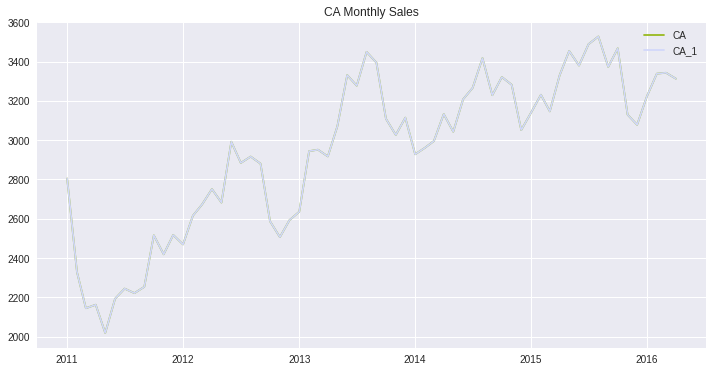

In [4]:
plot_state_sales(final, 'CA')

In [ ]:
plot_state_sales(final, 'TX')

In [ ]:
plot_state_sales(final, 'WI')

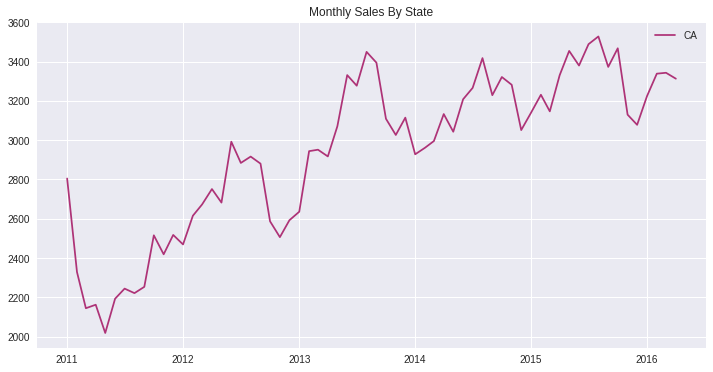

In [6]:
compare_state_sales(final);

---
## Functions

#### Ideally for a demand/forecasting problem, we'd want to drill down to the department and item level to determine how much inventory we need.

The Kaggle competition wants *item forecasting* for 2x 28 day periods.

* For exploring: `monthly_item_sales(df)`

---

Specify a state (case sensitive): ['CA'] 
CA
Specify a store: ['CA_1'] 
CA 1
Choose a department category to view items available
[] 
HOBBIES_1
Plot department sales? Yes or No. 
yes
Choose an item: 
HOBBIES_1_001


ValueError: ignored

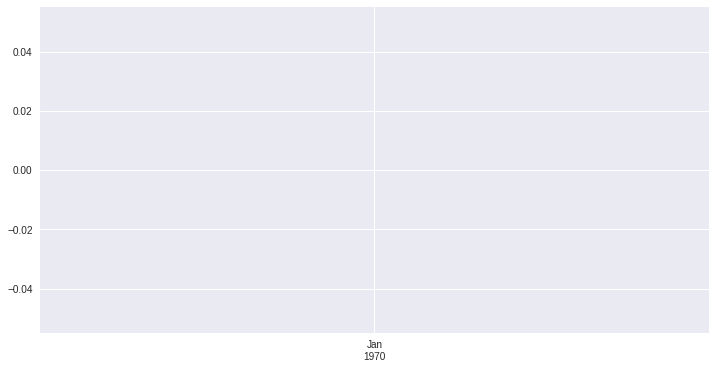

In [ ]:
monthly_item_sales(final)

In [ ]:
monthly_item_sales(final)

---
## Determining Stationarity & Prep for Modeling

Recall that **random walks**, although constructed from totally random components, can show very strong evidence of *trends*.  This is because random walks are **STICKY**, once they randomly elevate to an extreme value, subsequent values of the series are only small adjustments to previous values, so the value of the series tends to stay elevated.

Test for stationarity with the **Augmented Dickey-Fuller test** as follows:

  - $H_0$: The series is **not-stationary** (specifically, has a *unit root*).
  - $H_{\text{a}}$: The series is stationary.
  
It is available in stats models as [`tsa.stattools.adfuller`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html).

---

Proceed by looking at each state's monthly sales separately.

# NEEDS CLEANING BEYOND THIS POINT

In [ ]:
ca_df = final[final.state_id == 'CA'].copy()
tx_df = final[final.state_id == 'TX'].copy()
wi_df = final[final.state_id == 'WI'].copy()

In [ ]:
ca_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0


In [ ]:
ca_monthly_df = monthly_sales(ca_df)
# tx_monthly_df = monthly_sales(tx_df)
# wi_monthly_df = monthly_sales(wi_df)

In [ ]:
ca_monthly_df.head()

,item_sales
date,
2011-01-31,2805.000000
2011-02-28,2329.107143
2011-03-31,2144.741935
2011-04-30,2162.566667
2011-05-31,2018.774194


In [ ]:
# ca_monthly_df = ca_monthly_df.reset_index()

In [ ]:
ca_monthly_df.shape

(64, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



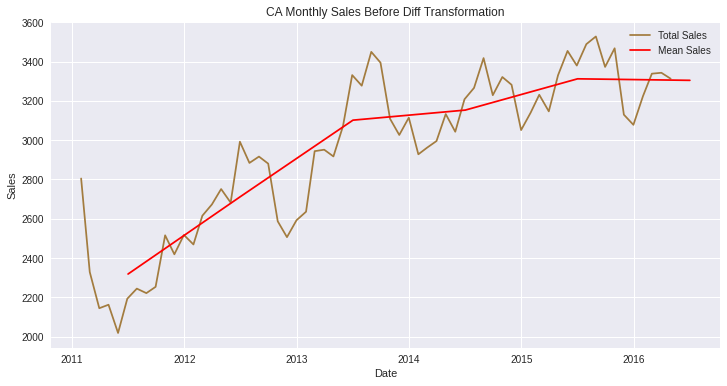

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ca_monthly_df.item_sales, color=gen_random_color(), label='Total Sales')
    
second = ca_monthly_df.groupby(ca_monthly_df.index.year)['item_sales'].mean().reset_index()
second.date = pd.to_datetime(second.date, format='%Y')
sns.lineplot((second.date + datetime.timedelta(6*365/12)), second.item_sales, data=second, ax=ax, color='red', label='Mean Sales')   
    
ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = 'CA Monthly Sales Before Diff Transformation')
    
sns.despine()

In [ ]:
# time_plot(ca_monthly_df, x_col=ca_monthly_df.date, y_col=ca_monthly_df.item_sales, title='CA Monthly Sales Before Diff Transformation')

KeyError: ignored

In [ ]:
ca_decomposition = sm.tsa.seasonal.seasonal_decompose(ca_monthly_df.resample('MS').mean())

fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, ca_monthly_df.resample('MS').mean(), ca_decomposition)
plt.tight_layout()

In [ ]:
time_plot(tx_monthly_df, 'date', 'item_sales', 'TX Monthly Sales Before Diff Transformation')

In [ ]:
tx_decomposition = sm.tsa.seasonal.seasonal_decompose(tx_monthly_df_decompose.resample('MS').mean())

fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, tx_monthly_df_decompose.resample('MS').mean(), tx_decomposition)
plt.tight_layout()

In [ ]:
time_plot(wi_monthly_df, 'date', 'item_sales', 'WI Monthly Sales Before Diff Transformation')

In [ ]:
wi_decomposition = sm.tsa.seasonal.seasonal_decompose(wi_monthly_df_decompose.resample('MS').mean())

fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, wi_monthly_df_decompose.resample('MS').mean(), wi_decomposition)
plt.tight_layout()

In [ ]:
ca_stationary = get_diff(ca_monthly_df, 'ca')
# tx_stationary = get_diff(tx_monthly_df, 'tx')
# wi_stationary = get_diff(wi_monthly_df, 'wi')

In [ ]:
ca_stationary.head()

,item_sales,sales_diff
date,,
2011-02-28,2329.107143,-475.892857
2011-03-31,2144.741935,-184.365207
2011-04-30,2162.566667,17.824731
2011-05-31,2018.774194,-143.792473
2011-06-30,2193.133333,174.359140


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



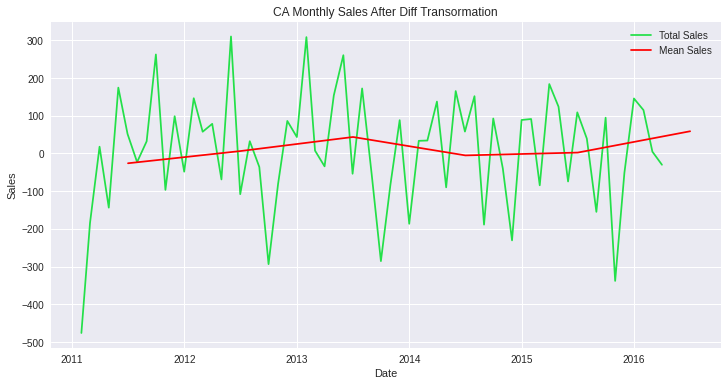

In [ ]:
time_plot(ca_stationary.reset_index(), 'date', 'sales_diff', 'CA Monthly Sales After Diff Transormation')

In [ ]:
test_ca = sm.tsa.stattools.adfuller(ca_stationary.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_ca[1]))

ADF p-value for python series: 0.00


In [ ]:
def get_seasonal_diff(data):
    data['sales_diff'] = data.item_sales.diff().diff(periods=12)
    data = data.dropna()
    return data

ca_seasonal_diff = get_seasonal_diff(ca_monthly_df)

In [ ]:
ca_seasonal_diff.head()

,item_sales,sales_diff
date,,
2012-02-29,2615.620690,622.158708
2012-03-31,2673.032258,241.776776
2012-04-30,2751.400000,60.543011
2012-05-31,2682.419355,74.811828
2012-06-30,2992.366667,135.588172


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



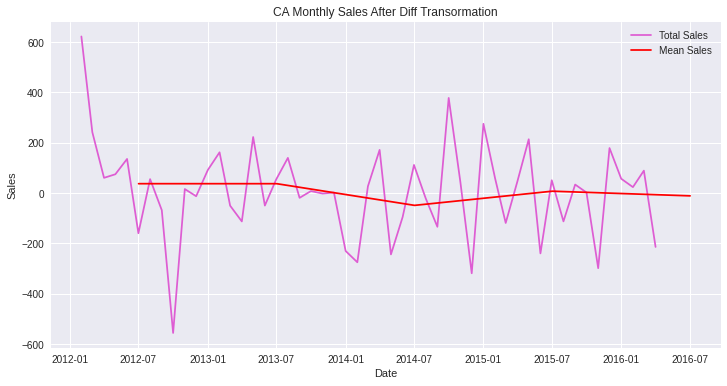

In [ ]:
time_plot(ca_seasonal_diff.reset_index(), 'date', 'sales_diff', 'CA Monthly Sales After Diff Transormation')

In [ ]:
test_ca = sm.tsa.stattools.adfuller(ca_seasonal_diff.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_ca[1]))

ADF p-value for python series: 0.00


In [ ]:
time_plot(tx_stationary, 'date', 'sales_diff', 'TX Monthly Sales After Diff Transormation')

In [ ]:
test_tx = sm.tsa.stattools.adfuller(tx_stationary.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_tx[1]))

In [ ]:
time_plot(wi_stationary, 'date', 'sales_diff', 'WI Monthly Sales After Diff Transormation')

In [ ]:
test_wi = sm.tsa.stattools.adfuller(wi_stationary.sales_diff)
print("ADF p-value for python series: {0:2.2f}".format(test_wi[1]))

---
## Autocorrelation
Each states' monthly sales are **stationary** according to the Augmented Dickey-Fuller Test.

One consequence of this definition is that the correlation between two $Y$'s only depends on the lag between them:

$$ Corr(Y_5, Y_2) = Corr(Y_4, Y_1) = Corr(Y_{144}, Y_{141}) = \cdots $$

These correlations between a time series and a lagged version of itself are called **autocorrelations**.

$$ \gamma_k(Y)= Corr(Y_1, Y_{1+k}) = Corr(Y_2, Y_{2+k}) = Corr(Y_3, Y_{3+k}) = \cdots $$

### Autocorrelation Plots
Each spike in this plot is an autocorrelation for a single lag. The *first* spike is always at $1.0$ (because any series is perfectly correlated with itself. The shaded region are 95% confidence bounds.  If *all* of the autocorrelations were truly zero, we would still expect to see about 5% of the spikes exceeding these bounds.

One potential issue with autocorrelations is the following:
    
If $y_i$ influences $y_{i+1}$ **and** $y_{i+1}$ influences $y_{i+2}$ then $y_{i}$ **necessarily** has some influence on $y_{i+2}$

---
An **ARIMA(p, d, q)** model:
  - Applies an ARMA model to a series that has been differenced $d$ times.
  - The Auto-Regression (AR) part of the ARMA model has order $p$. Where $p$ is how many past lags to include in the forecasting equation of an auto-regressive model.
  - The Moving-Average (MA) part of the ARMA model has order $q$. Where $q$ is how many seasonal lags to include.
  
*The following correlation plots are of 1-day differenced series. To understand MA $q$ order, plot monthly differenced series. This entails creating a monthly dataset (averages), and using `.shift(12)` to difference each month. Then assign to a different column.*

In [ ]:
ca_seasonal_diff = ca_seasonal_diff.drop('item_sales', axis=1)
ca_seasonal_diff.head()

,sales_diff
date,
2012-02-29,622.158708
2012-03-31,241.776776
2012-04-30,60.543011
2012-05-31,74.811828
2012-06-30,135.588172


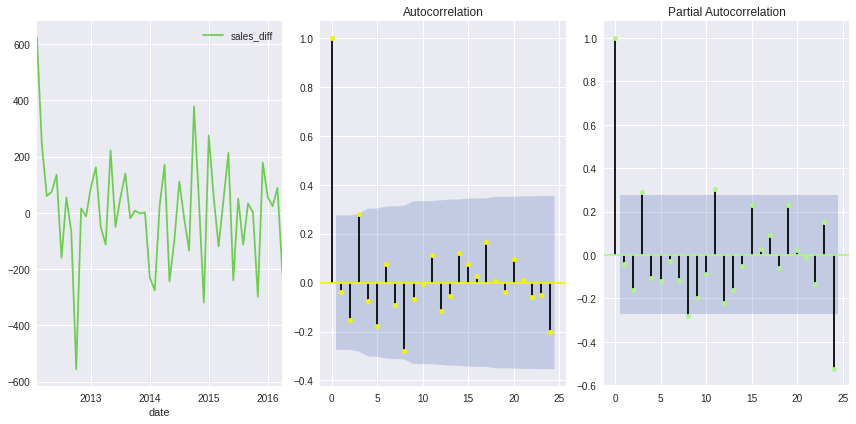

In [ ]:
layout = (1, 3)
raw  = plt.subplot2grid(layout, (0, 0))
acf  = plt.subplot2grid(layout, (0, 1))
pacf = plt.subplot2grid(layout, (0, 2))
    
ca_seasonal_diff.plot(ax=raw, figsize=(12, 6), color=gen_random_color())
smt.graphics.plot_acf(ca_seasonal_diff, lags=24, ax=acf, color=gen_random_color())
smt.graphics.plot_pacf(ca_seasonal_diff, lags=24, ax=pacf, color=gen_random_color())
sns.despine()
plt.tight_layout()

In [ ]:
ca_stationary.drop('sales_diff', axis=1, inplace=True)
ca_stationary.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,item_sales
date,
2011-02-28,2329.107143
2011-03-31,2144.741935
2011-04-30,2162.566667
2011-05-31,2018.774194
2011-06-30,2193.133333


In [ ]:
def train_test_spli_1(df):
    '''
    Returns train and test/holdout data ready for model training and evaluation.
    Different than regular train_test_split for time series specific problems.
        Cannot be randomized bc data is sequential.
    
    PARAMETERS
    ----------
        df: dataframe with monthly entries
    
    RETURNS
        train: series, training dataframe
        test: series, last 12 months for holdout/testing
    '''
    train, test = df[0:-12], df[-12:]
    
    return train, test

In [ ]:
X_train, X_test = train_test_spli_1(ca_stationary)

In [ ]:
X_train.shape, X_test.shape

((51, 1), (12, 1))

In [ ]:
print(X_train.head())
print(X_test.head())

             item_sales
date                   
2011-02-28  2329.107143
2011-03-31  2144.741935
2011-04-30  2162.566667
2011-05-31  2018.774194
2011-06-30  2193.133333
             item_sales
date                   
2015-05-31  3454.387097
2015-06-30  3380.000000
2015-07-31  3488.806452
2015-08-31  3528.032258
2015-09-30  3373.100000


In [ ]:
seasonal_difference_model = sm.tsa.statespace.sarimax.SARIMAX(
        X_train,
        order=(1, 1, 0),
        seasonal_order=(0, 1, 0, 12))
res = seasonal_difference_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         item_sales   No. Observations:                   51
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -249.813
Date:                            Thu, 06 May 2021   AIC                            503.625
Time:                                    20:57:55   BIC                            506.900
Sample:                                02-28-2011   HQIC                           504.790
                                     - 04-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1012      0.206     -0.492      0.623      -0.504       0.302
sigma2       3.01e+04   5247.011      5.736      0.000    1.98e+04    4.04e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 7.15
Prob(Q):                               nan   Prob(JB):                         0.03
Heteroskedasticity (H):               0.94   Skew:                            -0.78
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_hat = res.predict(X_test.index[0], X_test.index[-1])

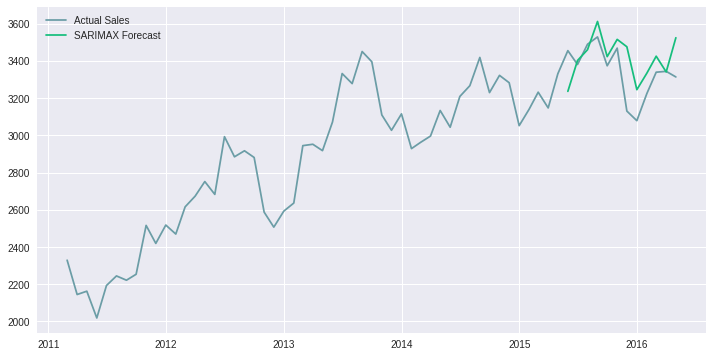

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ca_stationary, c=gen_random_color(), label='Actual Sales')
ax.plot(y_hat, c=gen_random_color(), label='SARIMAX Forecast')
ax.legend();

In [ ]:
np.sum(((X_test.item_sales.values - y_hat)**2)**(1/2))

1369.790182391473

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
def grid_search_sarimax(params):
    rmses = []
    aics = []
    for p in params['p']:
        for d in params['d']:
            for q in params['q']:
                for P in params['P']:
                    for D in params['D']:
                        for Q in params['Q']:
                            for s in params['s']:
                                for t in params['trend']:
                                    model = SARIMAX(X_train, order=(p,d,q), seasonal_order=(P,D,Q,s), trend=t)
                                    res = model.fit()
                                    y_hat = res.predict(X_test.index[0], X_test.index[-1])
                                    rmses.append(np.sum(((X_test.item_sales.values - y_hat)**2)**(1/2)))
                                    aics.append(res.aic)
    return rmses, aics

In [ ]:
params = {
    'p':(0,1,2),
    'd':(0,1,2),
    'q':(0,1,2),
    'P':(0,1,2),
    'D':(0,1,2),
    'Q':(0,1,2),
    's':(1,7,12),
    'trend':('n','c','t','ct')
}

In [ ]:
grid_search_sarimax(params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ValueError: ignored

In [ ]:
nearby_parameters = [
    {'AR': 0, 'MA': 0},
    {'AR': 1, 'MA': 0},
    {'AR': 0, 'MA': 1},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 0}    
]

results = []
for params in nearby_parameters:
    seasonal_difference_model = sm.tsa.statespace.sarimax.SARIMAX(
        ca_seasonal_diff,
        order=(params['MA'], 1, params['AR']),
        seasonal_order=(0, 1, 0, 12))
    res = seasonal_difference_model.fit()
    results.append(res)

In [ ]:
for item in results:
    print(f'{item}')
    print(f'AIC: {item.aic}')
    print(f'BIC: {item.bic}\n')

In [ ]:
model = results[1]
model.summary()

In [ ]:
# sigma reps variance in residuals
y_hat = model.predict()

In [ ]:
correlation_plots(ca_seasonal_diff, lags=);

*Observations*
* AR(6)
* MA()

In [ ]:
correlation_plots(tx_stationary, lags=30);

In [ ]:
correlation_plots(wi_stationary, lags=30);

---
## Proceeding with [Supervised Learning for Time Series Forecasting](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/)

* "Restructure the time series datasets as a supervised learning problem by using the value at the previous time step to predict the value at the next time-step.


* This representation is called a sliding window, as the window of inputs and expected outputs is shifted forward through time to create new “samples” for a supervised learning model.


* We can use the shift() function in Pandas to automatically create new framings of time series problems given the desired length of input and output sequences.

This would be a useful tool as it would allow us to explore different framings of a time series problem with machine learning algorithms to see which might result in better-performing models." --Machine Learning Mastery

---

In [ ]:
#the `monthly_df_decompose` versions had dates for index
ca_df = clean_df(ca_monthly_df_decompose, 'ca')
tx_df = clean_df(tx_monthly_df_decompose, 'tx')
wi_df = clean_df(wi_monthly_df_decompose, 'wi')
ca_df.head()

In [ ]:
# Guessing that there is a 12-month seasonality
ca_supervised = generate_supervised(ca_df, 'ca', 12)
tx_supervised = generate_supervised(tx_df, 'tx', 12)
wi_supervised = generate_supervised(wi_df, 'wi', 12)

In [ ]:
ca_supervised.head()

*******************************************

***************************************************************************

***************************************************************************

**For the COLAB notebook, start here after import functions in first cell!**

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
final = pd.read_csv('final.csv')
final_small = pd.read_csv('final_small.csv')

In [5]:
def windowize_data(data, n_prev, y_var='y', predict_steps=365):
    n_predictions = len(data) - n_prev
    y = data[y_var].iloc[n_prev:].values
    y_indices = np.arange(predict_steps) + np.arange(len(y) - predict_steps+1)[:, None]
    y = y[y_indices]
    x_indices = np.arange(n_prev) + np.arange(n_predictions- predict_steps+1)[:, None]
    x = data.values[x_indices]
    return x, y

In [6]:
final.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0


In [7]:
final.shape

(5000001, 14)

In [8]:
ca_df = final[final.state_id == 'CA'].copy()
tx_df = final[final.state_id == 'TX'].copy()
wi_df = final[final.state_id == 'WI'].copy()

In [9]:
ca_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,item_sales,date,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,0,0,0,0.0


In [12]:
pd.unique(ca_df['id'])

array(['HOBBIES_1_001_CA_1_evaluation', 'HOBBIES_1_002_CA_1_evaluation',
       'HOBBIES_1_003_CA_1_evaluation', ...,
       'FOODS_3_399_CA_1_evaluation', 'FOODS_3_400_CA_1_evaluation',
       'FOODS_3_401_CA_1_evaluation'], dtype=object)

In [18]:
FOODS_1_001_CA_1_evaluation = ca_df.groupby(['id','date']).mean().loc['FOODS_1_001_CA_1_evaluation']

In [19]:
FOODS_1_001_CA_1_evaluation.shape

(1904, 6)

In [20]:
FOODS_1_001_CA_1_evaluation.head()

,item_sales,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,
2011-01-29,3.0,11101,0,0,0,2.0
2011-01-30,0.0,11101,0,0,0,2.0
2011-01-31,0.0,11101,0,0,0,2.0
2011-02-01,1.0,11101,1,1,0,2.0
2011-02-02,4.0,11101,1,0,1,2.0


In [21]:
test_size = 365

In [24]:
train = FOODS_1_001_CA_1_evaluation.iloc[:-test_size,:].copy()
test = FOODS_1_001_CA_1_evaluation.iloc[-test_size:,:].copy()

In [25]:
train

,item_sales,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,
2011-01-29,3.0,11101,0,0,0,2.00
2011-01-30,0.0,11101,0,0,0,2.00
2011-01-31,0.0,11101,0,0,0,2.00
2011-02-01,1.0,11101,1,1,0,2.00
2011-02-02,4.0,11101,1,0,1,2.00
...,...,...,...,...,...,...
2015-04-12,2.0,11511,0,1,1,2.24
2015-04-13,1.0,11511,0,1,0,2.24
2015-04-14,1.0,11511,0,0,1,2.24


In [26]:
test

,item_sales,wm_yr_wk,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,
2015-04-17,0.0,11511,0,0,0,2.24
2015-04-18,0.0,11512,0,0,0,2.24
2015-04-19,1.0,11512,0,0,0,2.24
2015-04-20,0.0,11512,0,0,0,2.24
2015-04-21,0.0,11512,0,0,0,2.24
...,...,...,...,...,...,...
2016-04-11,2.0,11611,0,1,1,2.24
2016-04-12,0.0,11611,0,1,1,2.24
2016-04-13,1.0,11611,0,1,0,2.24


In [28]:
X_train = train.drop('item_sales', axis=1)
y_train = train['item_sales']

In [30]:
X_test = test.drop('item_sales', axis=1)
y_test = test['item_sales']

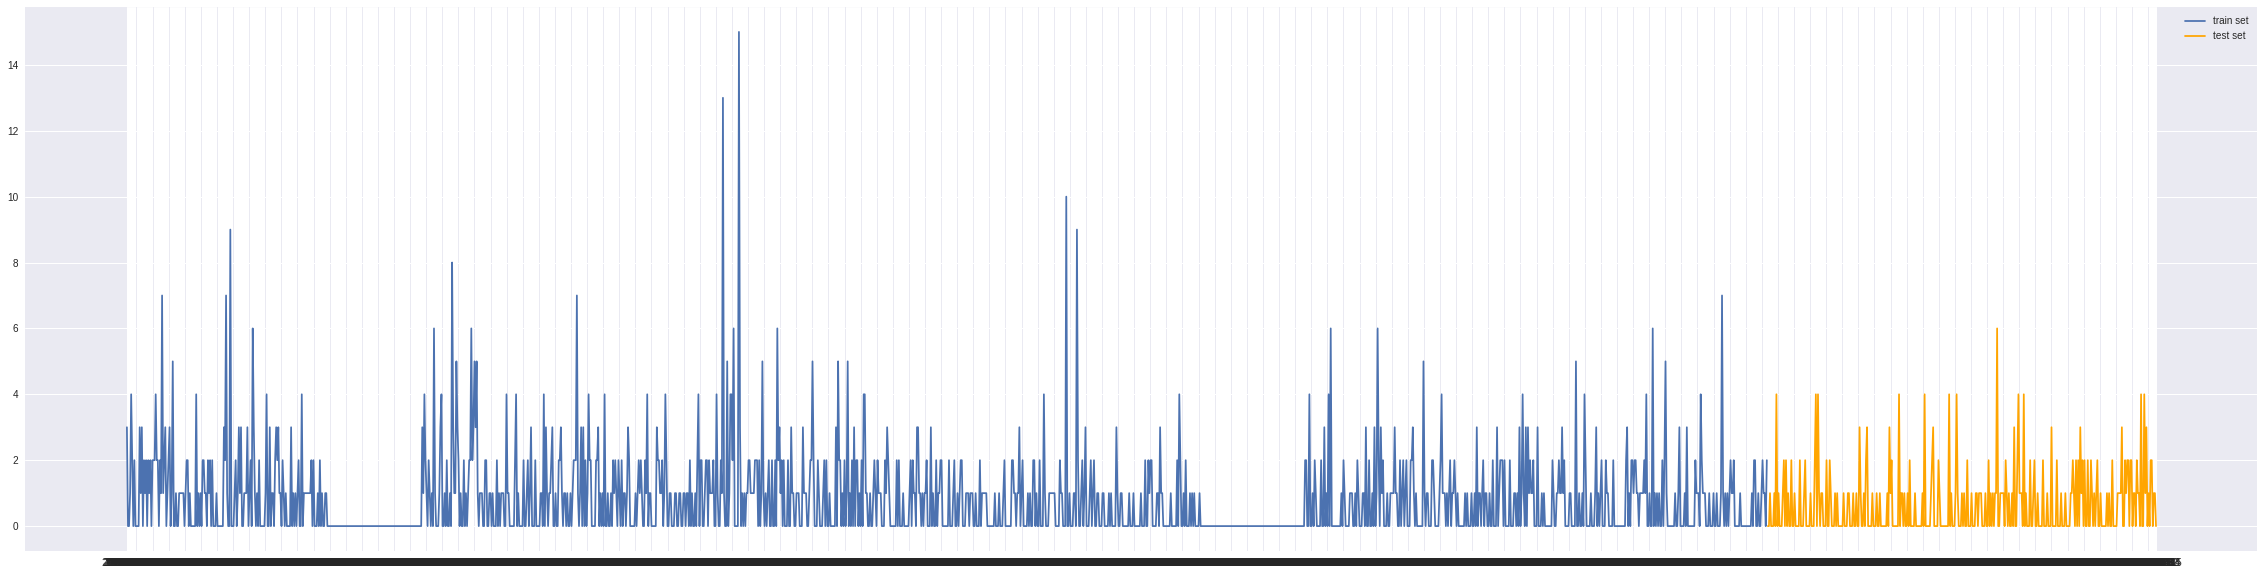

In [32]:
plt.figure(figsize=(40,10))
plt.plot(train.index,train['item_sales'],label='train set');
plt.plot(test.index,test['item_sales'],label='test set', color='orange')
plt.legend();

In [33]:
n_prev = 28
predict_steps = 28

In [37]:
X_train_window, y_train_window = windowize_data(train, n_prev, 'item_sales', predict_steps)
X_test_window, y_test_window = windowize_data(test, n_prev, 'item_sales', predict_steps)

In [40]:
X_train_window.shape

(1484, 28, 6)

In [47]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_prev, 6), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(predict_steps, activation='linear'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='mse')

In [48]:
tf.config.run_functions_eagerly(True)

In [49]:
model.fit(X_train_window, y_train_window, batch_size=32, epochs=10, validation_data=(X_test_window, y_test_window))

Epoch 1/10
 1/47 [..............................] - ETA: 6s - loss: 2.3432

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



47/47 [==============================] - 7s 146ms/step - loss: 2.3573 - val_loss: 1.2833
Epoch 2/10
47/47 [==============================] - 6s 138ms/step - loss: 2.1170 - val_loss: 1.1037
Epoch 3/10
47/47 [==============================] - 6s 135ms/step - loss: 1.9120 - val_loss: 1.0386
Epoch 4/10
47/47 [==============================] - 6s 138ms/step - loss: 1.7812 - val_loss: 1.0249
Epoch 5/10
47/47 [==============================] - 6s 136ms/step - loss: 1.7687 - val_loss: 1.0214
Epoch 6/10
47/47 [==============================] - 6s 137ms/step - loss: 1.6281 - val_loss: 1.0244
Epoch 7/10
47/47 [==============================] - 6s 137ms/step - loss: 1.6834 - val_loss: 1.0234
Epoch 8/10
47/47 [==============================] - 7s 139ms/step - loss: 1.6733 - val_loss: 1.0252
Epoch 9/10
47/47 [==============================] - 6s 138ms/step - loss: 1.6738 - val_loss: 1.0269
Epoch 10/10
47/47 [==============================] - 6s 135ms/step - loss: 1.6653 - val_loss: 1.0258
